<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Machine_Learning_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Set working directory and import cookbook
os.chdir("/content/drive/My Drive/Colab Notebooks/")

#Download eeg feature extraction function
%run EEG_Feature_Extraction.ipynb

# **Import Data**

In [0]:
#Compute EEG feature
os.chdir("/content/drive/My Drive/EEG Data")
subjectID = ['SS2', 'SS4', 'SS5', 'SS6', 'SS7', 'SS8']
EEG_feature = extract_feature(subjectID)

In [0]:
os.chdir("/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA")

#Import FCSRT
FCSRT = pd.read_csv("FCSRT.csv")
FCSRT_o = FCSRT.iloc[[2, 3, 4, 5, 6, 7], 1:]
FCSRT_o = FCSRT_o.reset_index(drop = True)

#Import MoCA
MoCA = pd.read_csv("MoCA.csv", usecols = ['MoCA'])
MoCA_o = MoCA.iloc[[1, 3, 4, 5, 6, 7],:]
MoCA_o = MoCA_o.reset_index(drop = True)

#Import EEG
EEG = pd.read_csv("EEG_features(relative PSD).csv")
EEG.drop('id', axis = 1, inplace = True)

#Create group
Group = pd.DataFrame(data = {'group':(1,0,1,1,0,0)}) #0 = normal, 1 = risk

#Combined data
df_original = pd.concat([Group, EEG, FCSRT_o , MoCA_o] , axis = 1)
df_original['group'] = df_original['group'].astype('category') 

**Get data summary**

In [0]:
def mean_confidence_interval(data, confidence=0.95):
  import numpy as np
  import scipy.stats  
  a = 1.0 * np.array(data)
  n = len(a)
  m, se = np.mean(a), scipy.stats.sem(a)
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return m-h, m+h

In [0]:
df = df_original.drop(['group'], axis = 1)
ci = pd.DataFrame(columns=['lower', 'upper'])
for x in range(len(df.columns)):
  ci.loc[x] = mean_confidence_interval(df.iloc[:,x])
describe = df.describe().transpose()
describe['lower'] = ci['lower'].values
describe['upper'] = ci['upper'].values

describe.to_csv('Descriptive.csv', index = False)

# **Data Preprocessing**

In [0]:
from sklearn import preprocessing

In [0]:
#Min-Max Scaling
df = df_original.copy()

scaler = preprocessing.MinMaxScaler()
columns = ['IR-MSF', 'IR-SE', 'IR-AC', 'IR-wSMI_Alpha', 'IR-wSMI_Theta',
           'DL-MSF', 'DL-SE', 'DL-AC', 'DL-wSMI_Alpha', 'DL-wSMI_Theta',
           'WCST-MSF']
df[columns] = scaler.fit_transform(df[columns])

In [0]:
#Percentage
df['IR-FreeR'] = (df_original['IR-FreeR'])/16
df['IR-CuedR'] = (df_original['IR-CuedR'])/(16-df_original['IR-FreeR'])
df['DL-FreeR'] = (df_original['DL-FreeR'])/16
df['DL-CuedR'] = (df_original['DL-CuedR'])/(16-df_original['DL-FreeR'])

df['IR-FreeR'] = (df_original['IR-FreeR'])/16
df['IR-CuedR'] = (df_original['IR-CuedR'])/(16-df_original['IR-FreeR'])
df['DL-FreeR'] = (df_original['DL-FreeR'])/16
df['DL-CuedR'] = (df_original['DL-CuedR'])/(16-df_original['DL-FreeR'])
df.drop(df.iloc[:, 21:27].columns, axis = 1, inplace = True)

# **Model Experimentation**

####**1) Seperate dataframe**


1.   Only EEG & MoCA data
2.   FCSRT & MoCA data
3. All data


In [0]:
#1 Cognitive Markers Modeling
X_1 = df.iloc[:,21:26].values
#2 Biomarkers Modeling
X_2 = df.iloc[:,1:21].values
#3 Both
X_3 = df.iloc[:,1:].values

y = df['group']

####**2) Seperate *Training Set* and *Test Set***

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#X_1
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y, test_size = 0.25, random_state = 0)

#X_2
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y, test_size = 0.25, random_state = 0)

#X_3
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y, test_size = 0.25, random_state = 0)

####**3) Model Building**

In [0]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz

In [0]:
clf_svm_1 = SVC(kernel = 'rbf', random_state = 0)
clf_svm_1.fit(X_1_train, y_1_train)
svm_y_1_pred = clf_svm_1.predict(X_1_test)

clf_svm_2 = SVC(kernel = 'rbf', random_state = 0)
clf_svm_2.fit(X_2_train, y_2_train)
svm_y_2_pred = clf_svm_2.predict(X_2_test)

clf_svm_3 = SVC(kernel = 'rbf', random_state = 0)
clf_svm_3.fit(X_3_train, y_3_train)
svm_y_3_pred = clf_svm_3.predict(X_3_test)

In [0]:
clf_dt_1 = DecisionTreeClassifier()
clf_dt_1.fit(X_1_train, y_1_train)
dt_y_1_pred = clf_dt_1.predict(X_1_test)

clf_dt_2 = DecisionTreeClassifier()
clf_dt_2.fit(X_2_train, y_2_train)
dt_y_2_pred = clf_dt_2.predict(X_2_test)

clf_dt_3 = DecisionTreeClassifier()
clf_dt_3.fit(X_3_train, y_3_train)
dt_y_3_pred = clf_dt_3.predict(X_3_test)

####**4) Model Evaluation**

In [0]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, plot_confusion_matrix

####**SVM**

Text(0.5, 1.0, 'Both')

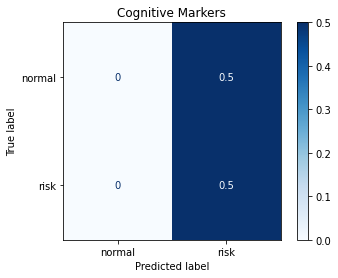

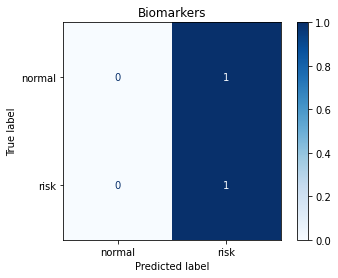

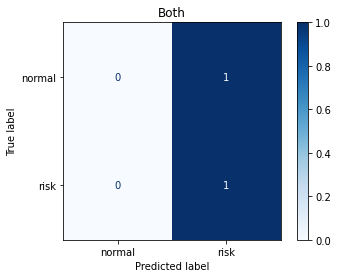

In [29]:
svm_1 = plot_confusion_matrix(clf_svm_1, X_1_test, y_1_test, display_labels = ['normal', 'risk'], cmap=plt.cm.Blues, normalize = 'true')
svm_1.ax_.set_title('Cognitive Markers')

svm_2 = plot_confusion_matrix(clf_svm_2, X_2_test, y_2_test, display_labels = ['normal', 'risk'], cmap=plt.cm.Blues, normalize = 'true')
svm_2.ax_.set_title('Biomarkers')

svm_3 = plot_confusion_matrix(clf_svm_3, X_3_test, y_3_test, display_labels = ['normal', 'risk'], cmap=plt.cm.Blues, normalize = 'true')
svm_3.ax_.set_title('Both')

In [30]:
print(classification_report(y_1_test, svm_y_1_pred))
print(classification_report(y_2_test, svm_y_2_pred))
print(classification_report(y_3_test, svm_y_3_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####**Decision Tree**

Text(0.5, 1.0, 'Both')

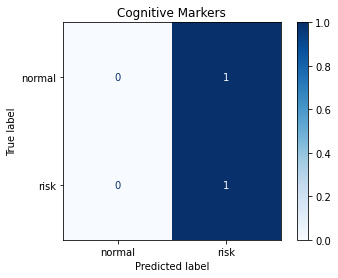

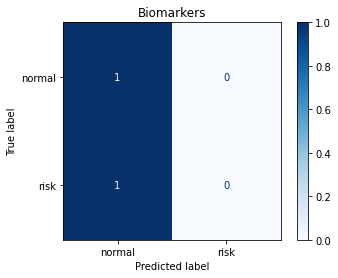

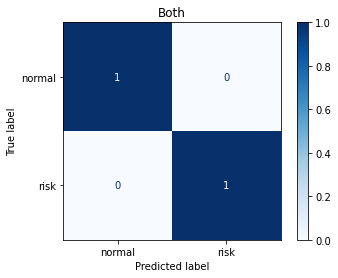

In [31]:
svm_1 = plot_confusion_matrix(clf_dt_1, X_1_test, y_1_test, display_labels = ['normal', 'risk'], cmap=plt.cm.Blues, normalize = 'true')
svm_1.ax_.set_title('Cognitive Markers')

svm_2 = plot_confusion_matrix(clf_dt_2, X_2_test, y_2_test, display_labels = ['normal', 'risk'], cmap=plt.cm.Blues, normalize = 'true')
svm_2.ax_.set_title('Biomarkers')

svm_3 = plot_confusion_matrix(clf_dt_3, X_3_test, y_3_test, display_labels = ['normal', 'risk'], cmap=plt.cm.Blues, normalize = 'true')
svm_3.ax_.set_title('Both')

In [32]:
print(classification_report(y_1_test, dt_y_1_pred))
print(classification_report(y_2_test, dt_y_2_pred))
print(classification_report(y_3_test, dt_y_3_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


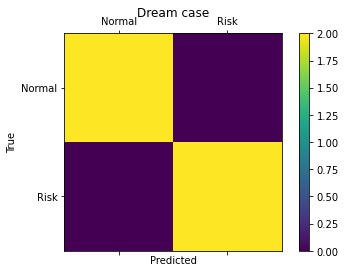

In [0]:
#Dream case
a = [0,0,1,1]
b = [0,0,1,1]

cm_3 = con_mat_picture(a, b, 'Dream case')